## Processing sensor data from Shale Hills CZO NPMS site ##

- Marc Berghouse 8/8/2020: Original format
- Zach Perzan 9/23/202: Improved format and working PRISM concat

This array includes:
- Apogee Instruments SO-110 O2 sensors
- Eosense EosGP CO2 sensors

Other data includes:
- PRISM daily precipitation




In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

def plot_cols(column_list, ylabel=''):
    """Plot columns from df. Columns to plot must be in
    column_list."""
    
    n = len(column_list)

    fig, ax = plt.subplots(n, figsize=(10,3*n), tight_layout=True, sharex=True)

    for i, col in enumerate(column_list):
        ax[i].plot(df.index, df[col], label=col)
        ax[i].legend(loc='upper right')
        ax[i].set(ylabel=ylabel)
        
    return fig, ax

In [2]:
infiles= ["../../raw_data/Shale Hills/NPMS/NPMS_CO2_O2.csv"  ]
df_list = []

for infile in tqdm(infiles):
    df = pd.read_csv(infile, na_values=['NAN', -9999],  parse_dates=[0], 
                     index_col=0) # skiprows=[1] skips the 1th row (0-indexed)
    df_list.append(df)
    
prism_path = "../../raw_data/Shale Hills/Precipitation/PRISM_Shale_Hills.csv" 
ppt = pd.read_csv(prism_path, na_values=['NAN',-9999,-99999], skiprows=11, 
                  parse_dates=[0], index_col=0, names=['PRISM_precip.mm']) 
ppt['PRISM_precip.mm'] = pd.to_numeric(ppt['PRISM_precip.mm'])

In [3]:
columns=["Record", "DiffVolt_20cm.mV", "DiffVolt_140cm.mV", "O2_20cm.percent.0-100", 
            "O2_140cm.percent.0-100",  "ApogeeTemp_20cm.deg.C" , "ApogeeTemp_140cm.deg.C", 
            "CO2lo_20cm.ppm","CO2hi_20cm.ppm", "GPTemp_20cm.deg.C", "CO2lo_140cm.ppm",
            "CO2hi_140cm.ppm", "GPTemp_140cm.deg.C"]

# Concatenate all individual files to a single dataframe
df = pd.concat(df_list)
df.columns = columns

# Resample everything to hourly averages since certain 
# sensors are measured on different schedules
df.sort_index(inplace=True) # Sort first
df = df.resample('1H').mean()
df
# Add on up-sampled PRISM data
# (resample daily to hourly, using the nearest value, then
#  add on as new column to df)
ppt = ppt.drop(pd.date_range('2014-01-01', '2016-08-16'), errors='ignore')
#ppt = ppt.drop(pd.date_range('2018-10-02', '2019-06-24'), errors='ignore')


hourly_ppt = ppt.resample('1H').nearest()
df.loc[hourly_ppt.index, 'PRISM_precip.mm'] = hourly_ppt['PRISM_precip.mm']

In [4]:
df=df.drop(columns="Record")
df=df.drop(columns="DiffVolt_20cm.mV")
df=df.drop(columns="DiffVolt_140cm.mV")


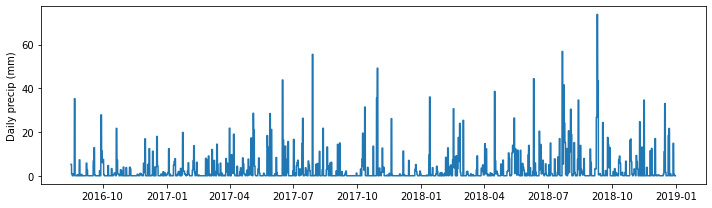

In [5]:
# Plot precip data
df['PRISM_precip.mm']=df['PRISM_precip.mm'].loc[:'2018-12-30']

fig, ax = plt.subplots(figsize=(10,3), tight_layout=True)

ax.plot(df.index, df['PRISM_precip.mm'])
ax.set(ylabel='Daily precip (mm)');




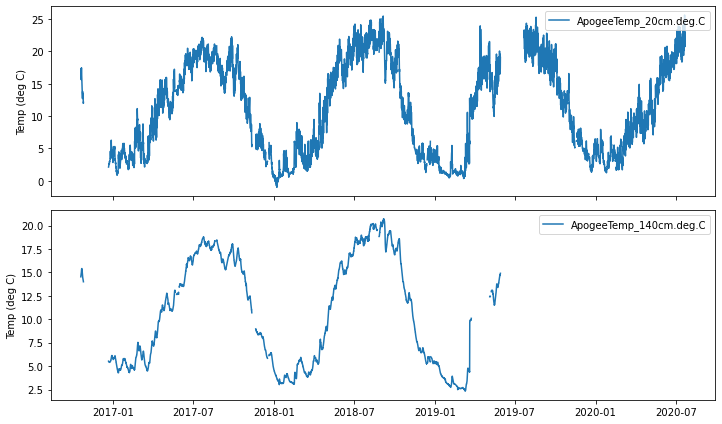

In [6]:
# Plot apogee thermistor temperature
df['ApogeeTemp_20cm.deg.C'].mask(df['ApogeeTemp_20cm.deg.C']<=-5, inplace=True)
df['ApogeeTemp_140cm.deg.C'].mask(df['ApogeeTemp_140cm.deg.C']<=-5, inplace=True)

df['ApogeeTemp_20cm.deg.C'].mask(df['ApogeeTemp_20cm.deg.C']>=100, inplace=True)
df['ApogeeTemp_140cm.deg.C'].mask(df['ApogeeTemp_140cm.deg.C']>=100, inplace=True)

apogee_temp_cols = [col for col in df.columns if 'ApogeeTemp' in col]
plot_cols(apogee_temp_cols, ylabel='Temp (deg C)');

In [7]:
df['ApogeeTemp_20cm.deg.C']=df['ApogeeTemp_20cm.deg.C'].loc[:'2018-12-30']

df=df.drop(columns='ApogeeTemp_140cm.deg.C')


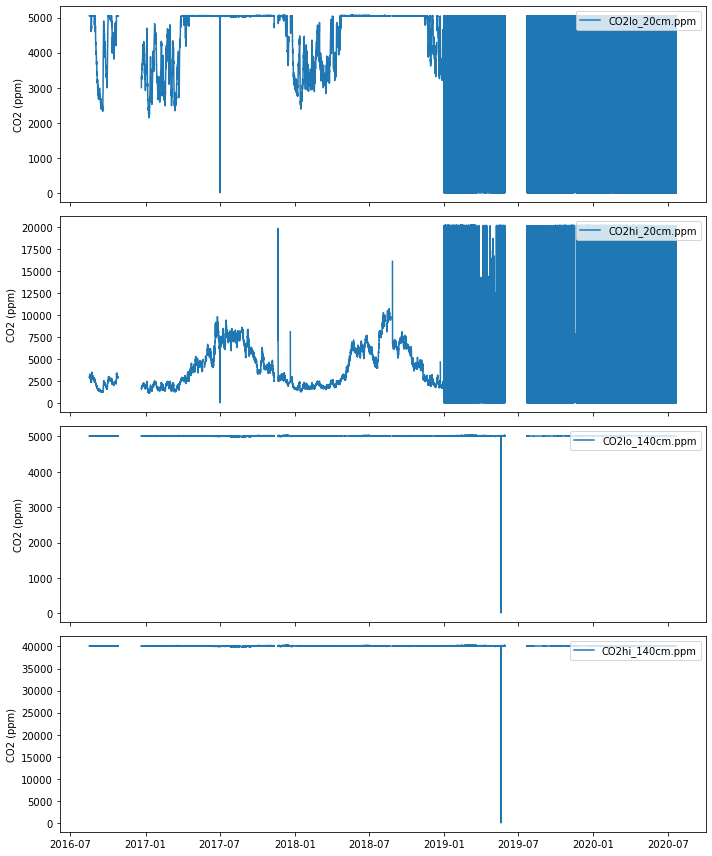

In [8]:
# Plot CO2 data
co2_cols = [col for col in df.columns if 'CO2' in col]
plot_cols(co2_cols, ylabel='CO2 (ppm)');

In [9]:
mask = df['CO2lo_20cm.ppm'] < 5000
df.loc[mask, 'CO2_20cm.ppm'] = df.loc[mask, 'CO2lo_20cm.ppm']
df.loc[~mask, 'CO2_20cm.ppm'] = df.loc[~mask, 'CO2hi_20cm.ppm']
mask2 = df['CO2lo_140cm.ppm'] < 5000
df.loc[mask2, 'CO2_140cm.ppm'] = df.loc[mask2, 'CO2lo_140cm.ppm']
df.loc[~mask2, 'CO2_140cm.ppm'] = df.loc[~mask2, 'CO2hi_140cm.ppm']

In [10]:
df=df.drop(columns='CO2lo_20cm.ppm')
df=df.drop(columns='CO2lo_140cm.ppm')
df=df.drop(columns='CO2hi_20cm.ppm')
df=df.drop(columns='CO2hi_140cm.ppm')
df['CO2_20cm.ppm']=df['CO2_20cm.ppm'].loc[:'2018-12-30']


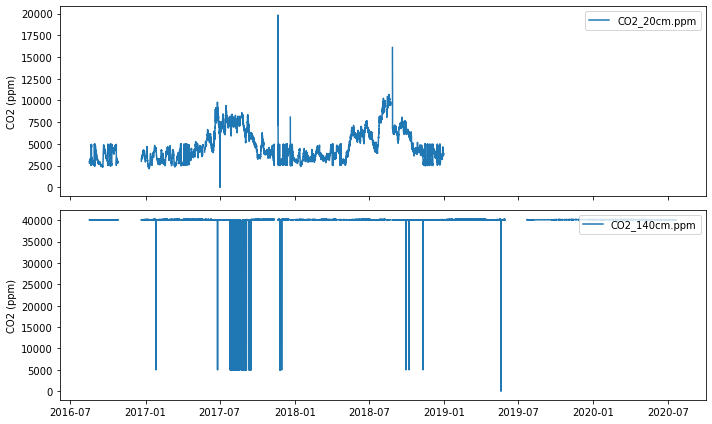

In [11]:
# Plot CO2 data
co2_cols = [col for col in df.columns if 'CO2' in col]
plot_cols(co2_cols, ylabel='CO2 (ppm)');

In [12]:
df=df.drop(columns='CO2_140cm.ppm')


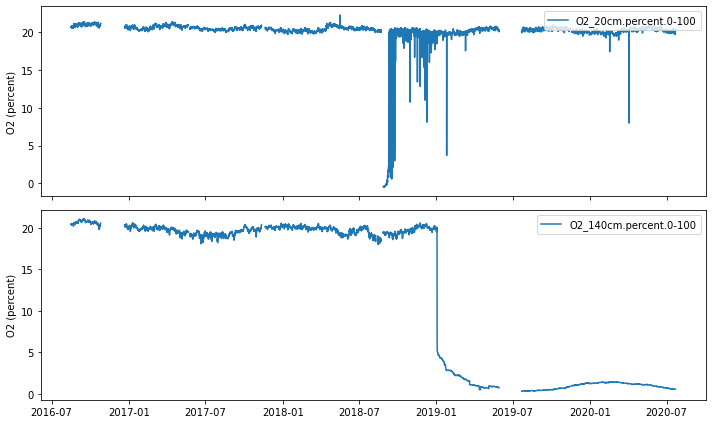

In [13]:
# Plot O2 data
o2_cols = [col for col in df.columns if col[:2] == 'O2']
plot_cols(o2_cols, ylabel='O2 (percent)');

In [14]:
df['O2_20cm.percent.0-100']=df['O2_20cm.percent.0-100'].loc[:'2018-12-30']


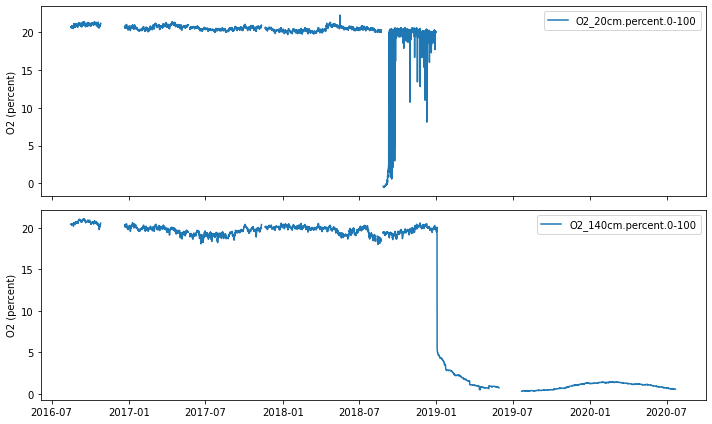

In [15]:
# Plot O2 data
o2_cols = [col for col in df.columns if col[:2] == 'O2']
plot_cols(o2_cols, ylabel='O2 (percent)');

In [16]:
df=df.drop(columns='O2_140cm.percent.0-100')


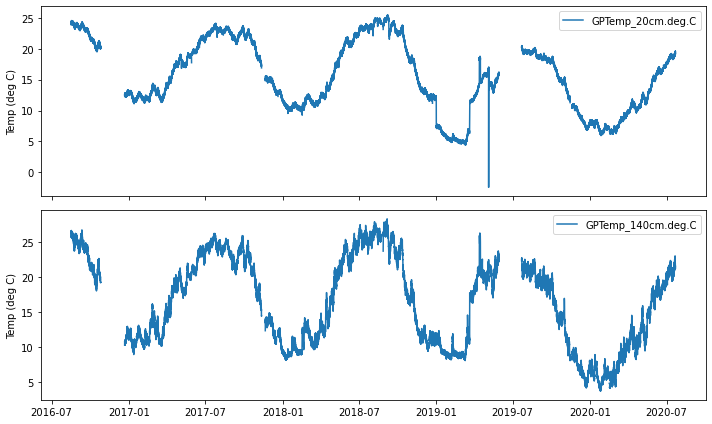

In [17]:
# Plot soil temperature from Decagon 5TE
dec_temp_cols = [col for col in df.columns if 'GPTemp' in col]

# There are several erroneous values less than -5 deg C
for col in dec_temp_cols:
    df[df[col] < -5] = np.nan
plot_cols(dec_temp_cols, ylabel='Temp (deg C)');

In [18]:
df=df.drop(columns='GPTemp_20cm.deg.C')
df=df.drop(columns='GPTemp_140cm.deg.C')



In [19]:
output=df.copy()
outfile = '../../processed_data/Shale_Hills/NPMS_CO2_O2_processed.csv'
output.to_csv(outfile, na_rep=-99999, index_label='DateTime.EST')

In [20]:
output

,O2_20cm.percent.0-100,ApogeeTemp_20cm.deg.C,PRISM_precip.mm,CO2_20cm.ppm
TmStamp,,,,
2016-08-16 12:00:00,20.690001,NaN,NaN,2985.0740
2016-08-16 13:00:00,20.610001,NaN,NaN,2957.9370
2016-08-16 14:00:00,20.610001,NaN,NaN,2887.4031
2016-08-16 15:00:00,20.580000,NaN,NaN,2854.9829
2016-08-16 16:00:00,20.580000,NaN,NaN,2795.1160
...,...,...,...,...
2020-07-21 14:00:00,NaN,NaN,NaN,NaN
2020-07-21 15:00:00,NaN,NaN,NaN,NaN
2020-07-21 16:00:00,NaN,NaN,NaN,NaN
